<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#loading-data" data-toc-modified-id="loading-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>loading data</a></span></li><li><span><a href="#target-analysis" data-toc-modified-id="target-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>target analysis</a></span></li><li><span><a href="#cross-validation" data-toc-modified-id="cross-validation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>cross validation</a></span></li><li><span><a href="#submission" data-toc-modified-id="submission-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>submission</a></span></li></ul></div>

In [1]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np

import os
import gc

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

plt.style.use('fivethirtyeight')
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

### loading data

In [2]:
train = pd.read_csv("Train.csv", index_col=None)
print(train.shape)
train.head()

(889, 13)


,Gender,Chain_smoker,Consumes_other_tobacco_products,HighBP,Obese,Diabetes,Metabolic_syndrome,Use_of_stimulant_drugs,Family_history,History_of_preeclampsia,CABG_history,Respiratory_illness,UnderRisk
0,1,1,1,0,1,0,0,0,1,0,0,0,no
1,1,0,1,0,1,0,0,0,1,0,0,0,no
2,1,0,1,0,1,0,0,0,1,0,0,0,no
3,1,0,1,0,1,0,0,0,1,0,0,0,no
4,1,0,0,0,0,0,1,1,0,0,0,0,no


In [3]:
target = 'UnderRisk'
cat_cols = ['Gender', 'Chain_smoker', 'Consumes_other_tobacco_products', 'HighBP', 'Obese', 'Diabetes',             'Metabolic_syndrome', 'Use_of_stimulant_drugs', 'Family_history', 'History_of_preeclampsia',             'CABG_history', 'Respiratory_illness']
num_cols = [col for col in train.columns if col not in [target]+cat_cols]
print("num cols {}".format(num_cols))

num cols []


In [4]:
test = pd.read_csv("Test.csv", index_col=None)
print(test.shape)
test.head()

(382, 12)


,Gender,Chain_smoker,Consumes_other_tobacco_products,HighBP,Obese,Diabetes,Metabolic_syndrome,Use_of_stimulant_drugs,Family_history,History_of_preeclampsia,CABG_history,Respiratory_illness
0,1,0,1,1,1,0,0,0,1,0,0,0
1,1,0,1,0,1,0,0,0,1,0,0,0
2,1,1,1,0,1,0,0,0,1,0,0,0
3,2,0,0,0,1,0,0,0,1,0,0,0
4,1,0,1,0,0,0,0,1,1,0,0,0


In [5]:
print("ratio of size of test to train {:0.2f}%".format(len(test)/len(train)*100))

ratio of size of test to train 42.97%


In [6]:
train[target] = train[target].map({'no':0, 'yes':1})

### target analysis

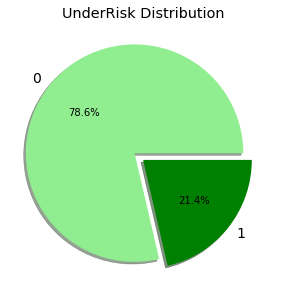

In [7]:
import seaborn as sns

f,ax=plt.subplots(figsize=(5,5))
train[target].value_counts().plot.pie(ax=ax,autopct='%1.1f%%',explode=[0.1,0],shadow=True,colors=['lightgreen','g'])
ax.set_title(f'{target} Distribution')
ax.set_ylabel('')
plt.show()

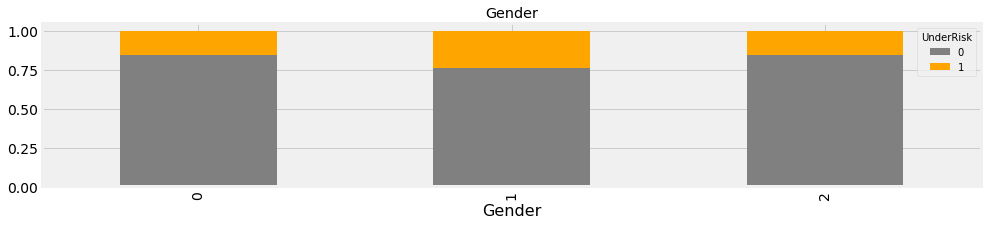

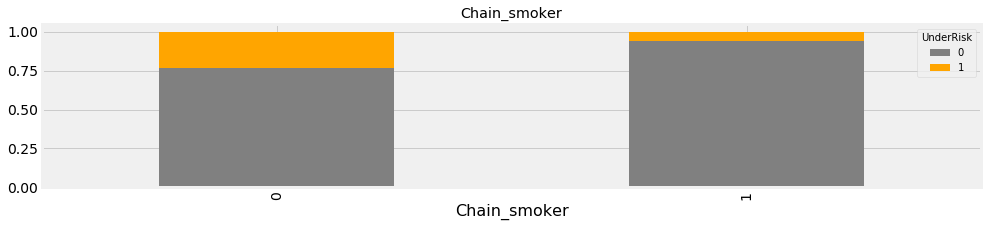

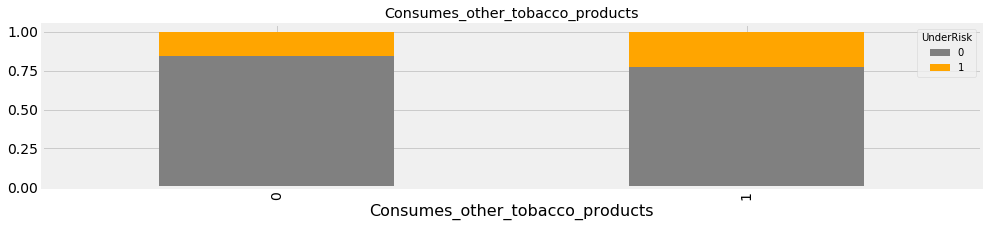

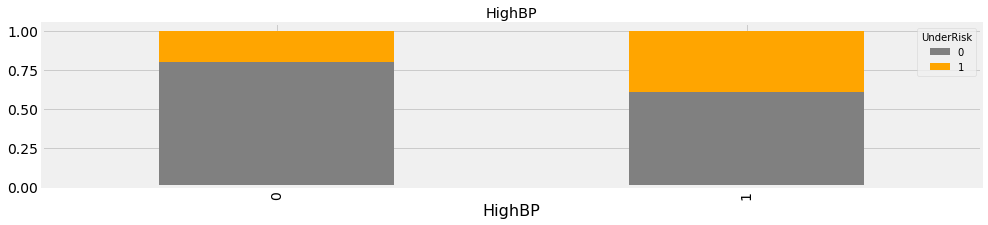

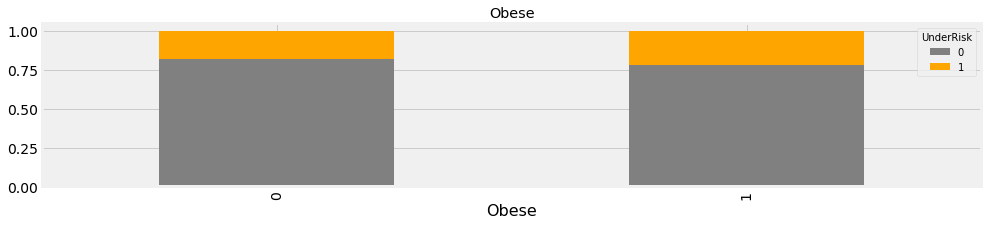

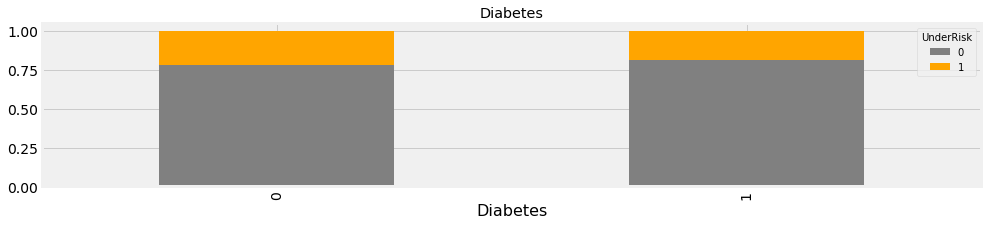

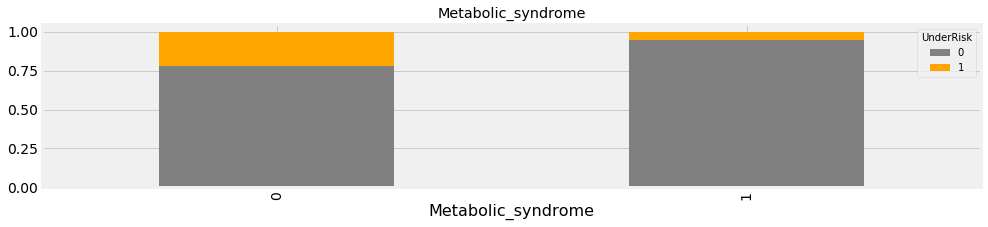

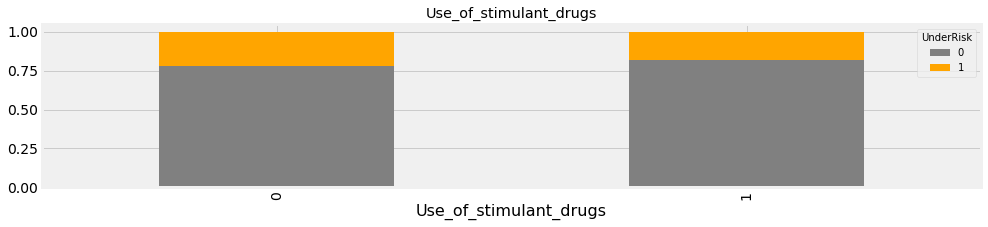

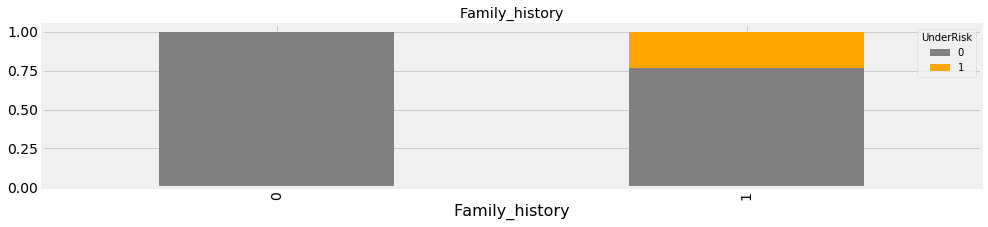

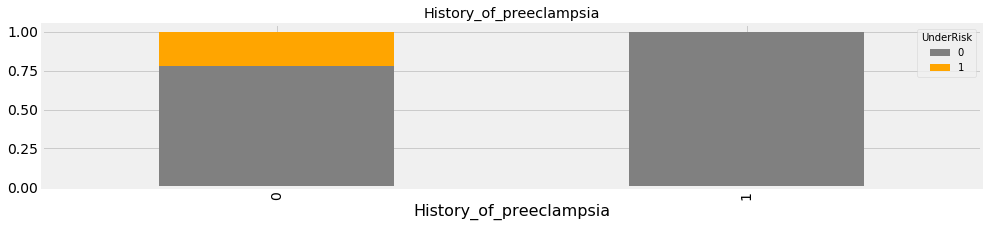

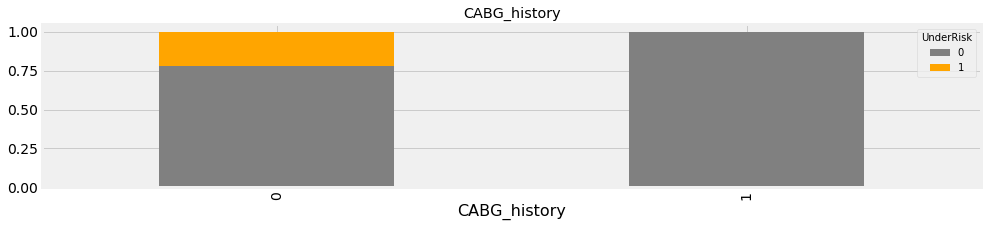

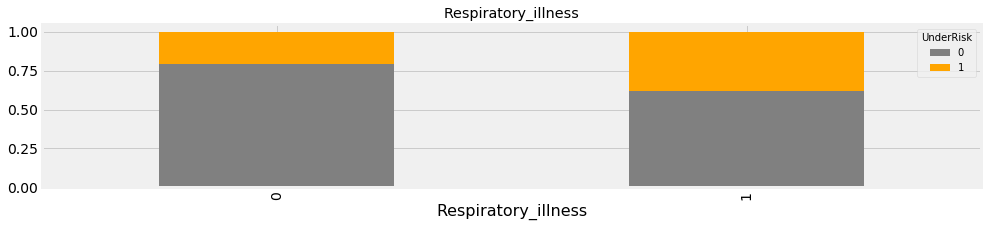

In [8]:
for col in cat_cols:
    pd.crosstab(train[col], train[target], normalize='index').plot(kind='bar', stacked=True, color=['grey','orange'], figsize=(15,3))
    plt.title(col)
    plt.show()

* from above, clearly patient with Family_history=0, History_of_preeclampsia=1 and CABG_history=1 are not under risk

### cross validation

In [9]:
drop_cols = ['CABG_history', 'Respiratory_illness',
       'Consumes_other_tobacco_products', 'Metabolic_syndrome',
       'History_of_preeclampsia', 'Obese', 'Use_of_stimulant_drugs',
       'Diabetes']

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

preds = []

valid_score_list = []
cv = StratifiedKFold(n_splits=10) 
for i, (train_ind, test_ind) in enumerate(cv.split(train, train[target])):
    data_train = train.iloc[train_ind].reset_index(drop=True)
    data_valid = train.iloc[test_ind].reset_index(drop=True)
    data_test = test.reset_index(drop=True)
#     print(data_train.shape, data_valid.shape)

    clf = RandomForestClassifier(n_jobs=-1, n_estimators=3000, min_samples_leaf=15)
    X_train = data_train.drop([target]+drop_cols, axis=1)
    X_valid = data_valid.drop([target]+drop_cols, axis=1)
    X_test = data_test.drop(drop_cols, axis=1)

    clf.fit(X_train, 
            data_train[target],)

    valid_prediction = clf.predict_proba(X_valid)
    
    # Manually updated the probabilities based on pattern observed in the data.
    valid_df = pd.DataFrame(valid_prediction, columns=['no', 'yes'])
    valid_df.loc[data_valid['Family_history'] == 0, 'yes'] = 0
    valid_df.loc[data_valid['Family_history'] == 0, 'no'] = 1

    valid_df.loc[data_valid['History_of_preeclampsia'] == 1, 'yes'] = 0
    valid_df.loc[data_valid['History_of_preeclampsia'] == 1, 'no'] = 1

    valid_df.loc[data_valid['CABG_history'] == 1, 'yes'] = 0
    valid_df.loc[data_valid['CABG_history'] == 1, 'no'] = 1
    
    valid_score = log_loss(data_valid[target], valid_df.values)
    valid_score_list.append(valid_score)
    print("FOLD:{} Score:{:0.2f}".format(i+1, valid_score))
    
    preds.append(clf.predict_proba(X_test))
    
print("CV score is {}".format(np.mean(valid_score_list)))

FOLD:1 Score:0.47
FOLD:2 Score:0.47
FOLD:3 Score:0.49
FOLD:4 Score:0.46
FOLD:5 Score:0.45
FOLD:6 Score:0.48
FOLD:7 Score:0.46
FOLD:8 Score:0.43
FOLD:9 Score:0.50
FOLD:10 Score:0.46
CV score is 0.4677491961850363


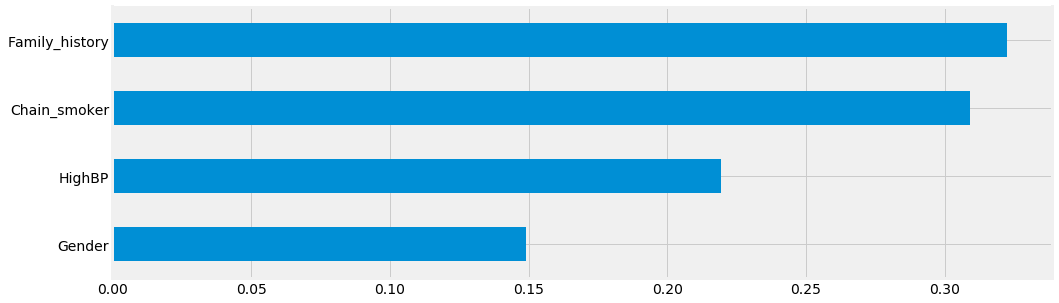

In [11]:
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh', figsize=(15,5))

### submission

In [12]:
prediction = np.mean(preds, axis=0)

In [13]:
sub = pd.DataFrame(prediction, columns=['no', 'yes'])
sub.loc[data_test['Family_history'] == 0, 'yes'] = 0
sub.loc[data_test['Family_history'] == 0, 'no'] = 1

sub.loc[data_test['History_of_preeclampsia'] == 1, 'yes'] = 0
sub.loc[data_test['History_of_preeclampsia'] == 1, 'no'] = 1

sub.loc[data_test['CABG_history'] == 1, 'yes'] = 0
sub.loc[data_test['CABG_history'] == 1, 'no'] = 1
sub.to_excel("model_rf_cv10_v1.xlsx", index=None)